# Week 3.3 Project

#### Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

#### Just make sure:

* to add enough Markdown cells to explain what you decided to do and to report any observations you make.
* to generate maps to visualize your neighborhoods and how they cluster together.

#### Once you are happy with your analysis, submit a link to the new Notebook on your Github repository. (3 marks)

In [16]:
!pip install folium
!pip install sklearn
import numpy as np
import pandas as pd
import folium
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler

## Import dataframe which we generated in Project 3.2

In [17]:
neigh_df = pd.read_pickle('3.2dataframe')
neigh_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Generate a map for Toronto to see all neighborhoods.

In [3]:
latitude = 43.7032
longitude = -79.3832

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

### Since the output of a folium map can't be viewed on GitHub, I just take a screenshot. It's something like this:
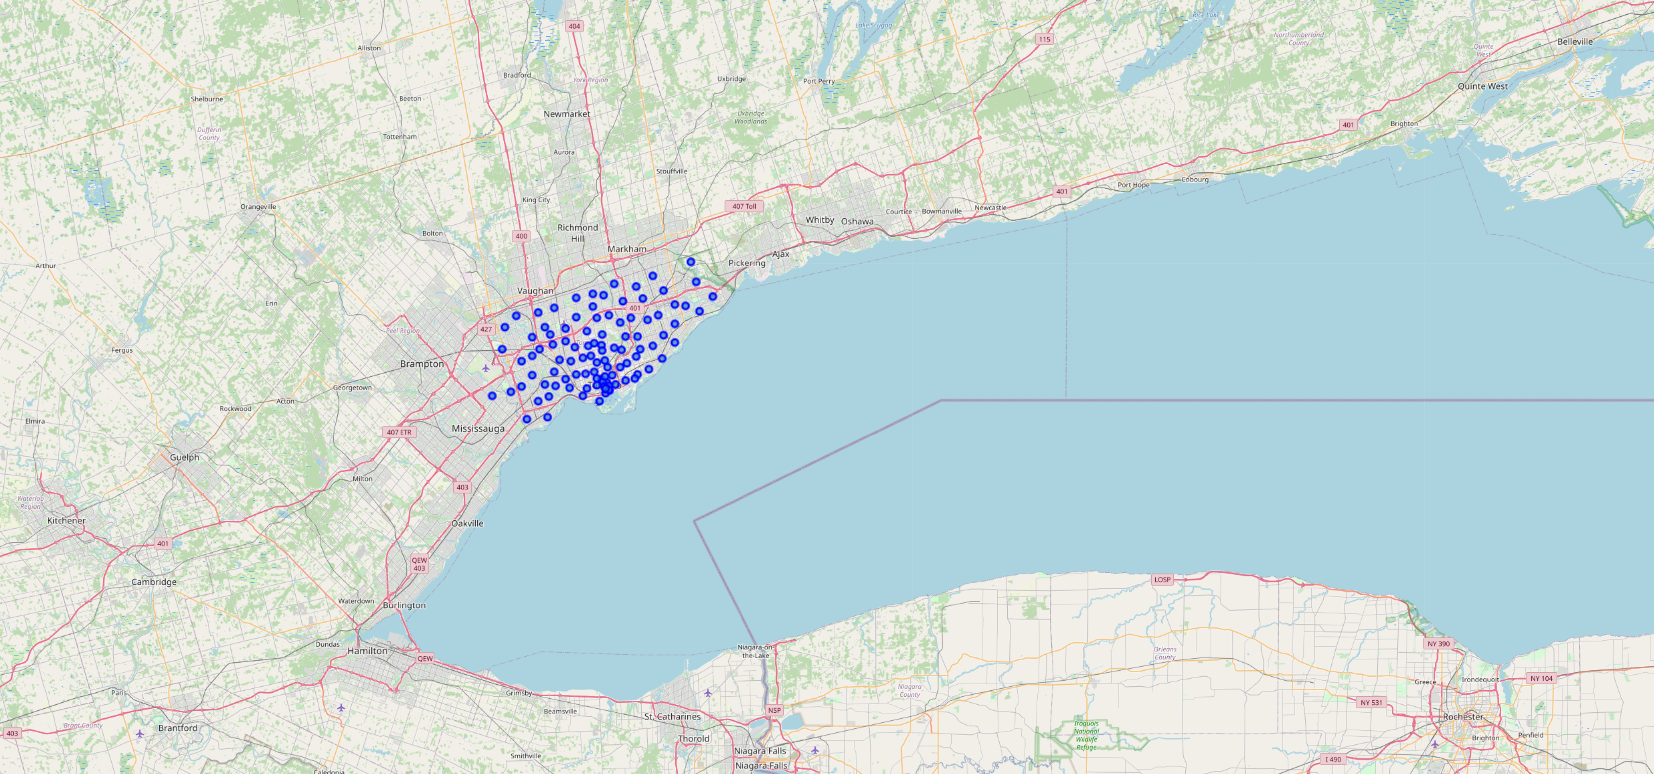

### Using FourSquare API to explore more.

In [4]:
CLIENT_ID = 'LVQ521WZ0ZVT1LNDBDI4FEC4TH5GTPFUJ3IQT21HTNJN4QUO'
CLIENT_SECRET = 'PUZJSH44LO0PW3S5BX4ISNSN1GBPBX0T55NBO4ELRQFTRAUA'
VERSION = '20180605'

#Create a method to get all the venues around a specific neighborhood. 

def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Use the function we defined to collect all venues in the neighborhood in Toronto.

In [5]:
toronto_venues = getNearbyVenues(names=neigh_df['Neighborhood'],
                                   latitudes=neigh_df['Latitude'],
                                   longitudes=neigh_df['Longitude']
                                  )

### Let's check the size of the resulting dataframe

In [6]:
print(toronto_venues.shape)
toronto_venues.head()

(2151, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern / Rouge,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,Malvern / Rouge,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
4,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum


### Let's check how many venues were returned for each neighborhood

In [7]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
Alderwood / Long Branch,10,10,10,10,10,10
Bathurst Manor / Wilson Heights / Downsview North,19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,24,24,24,24,24,24


### Construct a feature vector.

In [8]:
# encode data

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.insert(0, 'NeighborhoodName', toronto_venues['Neighborhood'])
toronto_grouped = toronto_onehot.groupby('NeighborhoodName').mean().reset_index()
toronto_grouped.head()

,NeighborhoodName,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alderwood / Long Branch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bedford Park / Lawrence Manor East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
toronto_grouped.shape

(93, 268)

### Get the top kind of venues at each neighborhood. 

In [10]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# Gop 10 venue categories for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['NeighborhoodName']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Lounge,Skating Rink,Breakfast Spot,Latin American Restaurant,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,Alderwood / Long Branch,Pizza Place,Pharmacy,Athletics & Sports,Dance Studio,Coffee Shop,Pub,Sandwich Place,Skating Rink,Gym,Antique Shop
2,Bathurst Manor / Wilson Heights / Downsview North,Coffee Shop,Bank,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket,Sushi Restaurant
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Bedford Park / Lawrence Manor East,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Sushi Restaurant,Greek Restaurant,Thai Restaurant,Cosmetics Shop,Pharmacy,Pizza Place


In [11]:
neigh_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### K-Mean Clustering

In [12]:
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('NeighborhoodName', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0], dtype=int32)

In [13]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neigh_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged .join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353,2.0,Fast Food Restaurant,Print Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dessert Shop
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,2.0,Construction & Landscaping,History Museum,Bar,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,2.0,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Electronics Store,Mexican Restaurant,Bank,Yoga Studio,Doner Restaurant,Distribution Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2.0,Coffee Shop,Korean Restaurant,Convenience Store,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2.0,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Bakery,Gas Station,Thai Restaurant,Caribbean Restaurant,Cuban Restaurant,Convenience Store


In [18]:
toronto_merged=toronto_merged.dropna(subset=['Cluster Labels'])
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype(int)
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353,2,Fast Food Restaurant,Print Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dessert Shop
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,2,Construction & Landscaping,History Museum,Bar,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,2,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Electronics Store,Mexican Restaurant,Bank,Yoga Studio,Doner Restaurant,Distribution Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2,Coffee Shop,Korean Restaurant,Convenience Store,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Bakery,Gas Station,Thai Restaurant,Caribbean Restaurant,Cuban Restaurant,Convenience Store
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,2,Playground,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,43.727929,-79.262029,2,Discount Store,Department Store,Hobby Shop,Coffee Shop,Train Station,Drugstore,Diner,Distribution Center,Dog Run,Doner Restaurant
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,43.711112,-79.284577,2,Bus Line,Bakery,Soccer Field,Ice Cream Shop,Bus Station,Metro Station,Intersection,Park,German Restaurant,Dim Sum Restaurant
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,43.716316,-79.239476,2,American Restaurant,Motel,Eastern European Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
9,M1N,Scarborough,Birch Cliff / Cliffside West,43.692657,-79.264848,2,College Stadium,Skating Rink,General Entertainment,Café,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

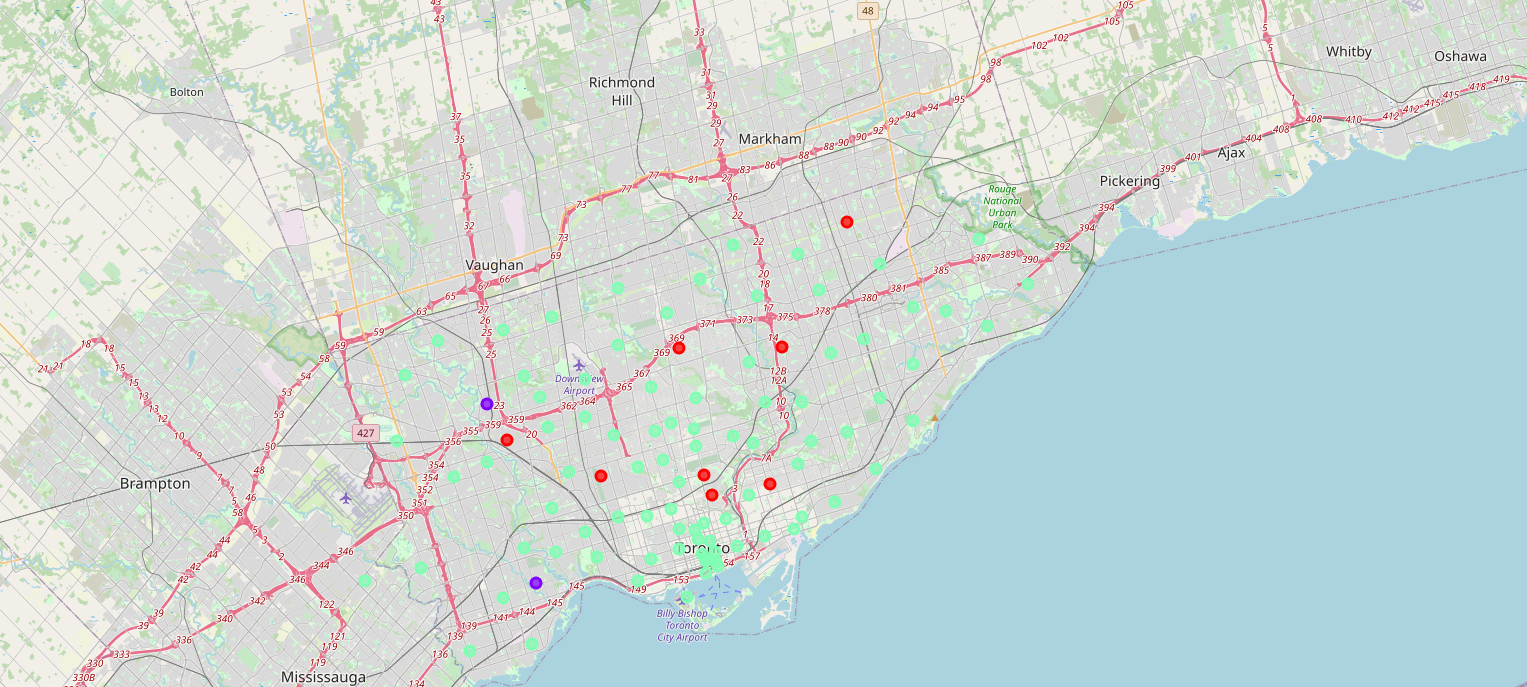

### Examine Clusters

### Cluster 1

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0.0,Playground,Park,Coffee Shop,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
23,North York,0.0,Park,Bank,Convenience Store,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
25,North York,0.0,Food & Drink Shop,Park,Eastern European Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
40,East York,0.0,Park,Convenience Store,Coffee Shop,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
48,Central Toronto,0.0,Park,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
50,Downtown Toronto,0.0,Park,Playground,Trail,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
74,York,0.0,Park,Women's Store,Spa,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
98,York,0.0,Park,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant


### Cluster 2

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,1.0,Baseball Field,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Filipino Restaurant
97,North York,1.0,Paper / Office Supplies Store,Baseball Field,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store


### Cluster 3

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2.0,Fast Food Restaurant,Print Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dessert Shop
1,Scarborough,2.0,Construction & Landscaping,History Museum,Bar,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Scarborough,2.0,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Electronics Store,Mexican Restaurant,Bank,Yoga Studio,Doner Restaurant,Distribution Center
3,Scarborough,2.0,Coffee Shop,Korean Restaurant,Convenience Store,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,Scarborough,2.0,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Bakery,Gas Station,Thai Restaurant,Caribbean Restaurant,Cuban Restaurant,Convenience Store
5,Scarborough,2.0,Playground,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
6,Scarborough,2.0,Discount Store,Department Store,Hobby Shop,Coffee Shop,Train Station,Drugstore,Diner,Distribution Center,Dog Run,Doner Restaurant
7,Scarborough,2.0,Bus Line,Bakery,Soccer Field,Ice Cream Shop,Bus Station,Metro Station,Intersection,Park,German Restaurant,Dim Sum Restaurant
8,Scarborough,2.0,American Restaurant,Motel,Eastern European Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
9,Scarborough,2.0,College Stadium,Skating Rink,General Entertainment,Café,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
